# Online Gradient Descent Based Portfolio Optimizer
Our portfolio optimizer relies on an online gradient descent based algorithm that looks to maximize our fitness function which combines soratino ratio, maximum drawdown, and expected returns. We trade with the Magnificient 7 stocks and train them over the dates of 2022-01-01 to 2023-12-31, using data provided by YFinance.

In [ ]:
# Standard data manipulation and numerical computation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# For parallel processing (if needed)
from multiprocessing import Pool

# For factor analysis
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

We begin by defining the fitness function as well as the necessary helper functions.

In [ ]:
def calculate_covariance_matrix(returns_df, window=252):
    """
    Calculate the covariance matrix of returns
    """
    return returns_df.rolling(window=window).cov().iloc[-1]

def calculate_expected_returns(prices_df, window=252, method='ewm'):
    """
    Calculate expected returns using exponentially weighted moving average

    Parameters:
    prices_df (pd.DataFrame): Historical price data
    window (int): Lookback period in trading days
    method (str): Method for calculating returns ('ewm' or 'simple')

    Returns:
    pd.Series: Expected returns for each asset
    """
    if method == 'ewm':
        returns = prices_df.pct_change().ewm(span=window).mean()
    else:
        returns = prices_df.pct_change().rolling(window=window).mean()
    return returns.iloc[-1]

def calculate_sortino_ratio(returns_df, risk_free_rate=0.02, window=252):
    excess_returns = returns_df - (risk_free_rate / 252)  # Daily risk-free rate
    negative_returns = excess_returns[excess_returns < 0]  # Only consider losses

    downside_std = np.sqrt(np.square(negative_returns).rolling(window=window).mean())

    expected_return = excess_returns.rolling(window=window).mean()

    sortino = expected_return / downside_std

    # Fix NaN issue
    sortino = sortino.replace([np.inf, -np.inf], np.nan).fillna(0)

    return sortino.iloc[-1]


def calculate_max_drawdown(prices_df, window=252):
    """
    Calculate maximum drawdown over a rolling window

    Parameters:
    prices_df (pd.DataFrame): Historical price data
    window (int): Lookback period in trading days

    Returns:
    float: Maximum drawdown
    """
    rolling_max = prices_df.rolling(window=window, min_periods=1).max()
    drawdown = prices_df / rolling_max - 1
    return drawdown.min()

def calculate_factor_exposure(returns_df, factor_returns, window=60):
    """
    Calculate factor exposures using rolling regression

    Parameters:
    returns_df (pd.DataFrame): Asset returns
    factor_returns (pd.DataFrame): Factor returns data
    window (int): Lookback period for factor analysis

    Returns:
    pd.DataFrame: Factor exposures for each asset
    """
    factor_exposures = pd.DataFrame()
    for asset in returns_df.columns:
        model = LinearRegression()
        y = returns_df[asset].iloc[-window:]
        X = factor_returns.iloc[-window:]
        model.fit(X, y)
        factor_exposures[asset] = model.coef_
    return factor_exposures

def portfolio_constraints(n_assets):
    """
    Generate basic portfolio constraints

    Parameters:
    n_assets (int): Number of assets in portfolio

    Returns:
    list: List of constraint dictionaries for scipy.optimize.minimize
    """
    # Constraint that weights sum to 1
    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    ]

    # Constraint that weights are between 0 and 1 (long-only)
    bounds = tuple((0, 1) for _ in range(n_assets))

    return constraints, bounds

def calculate_fitness(weights, prices_df, factor_returns=None,
                      alpha1=1.0, alpha2=1.0, alpha3=1.0, alpha4=0.5):
    returns_df = prices_df.pct_change().dropna()
    portfolio_returns = returns_df.dot(weights)

    # Calculate metrics
    expected_return = calculate_expected_returns(prices_df).dot(weights)
    sortino = calculate_sortino_ratio(portfolio_returns)
    max_dd = calculate_max_drawdown(prices_df.dot(weights))

    # Normalize components using typical ranges
    # Expected returns: normalize to [-0.5, 0.5] range
    norm_expected_return = expected_return / 0.5  # Assumes max yearly return of 50%

    # Sortino: normalize to [-3, 3] range
    norm_sortino = sortino / 3.0

    # Max drawdown: normalize to [-1, 0] range
    norm_max_dd = max_dd  # Already typically in [-1, 0] range

    # Calculate normalized fitness
    fitness = (alpha1 * norm_expected_return +
              alpha2 * norm_sortino -
              alpha3 * norm_max_dd)

    return -fitness if not np.isnan(fitness) else float('-inf')


def calculate_transaction_costs(old_weights, new_weights, cost_per_trade=0.001):
    """
    Calculate transaction costs for portfolio rebalancing

    Parameters:
    old_weights (np.array): Current portfolio weights
    new_weights (np.array): Target portfolio weights
    cost_per_trade (float): Transaction cost as a fraction of trade value

    Returns:
    float: Total transaction costs
    """
    return np.sum(np.abs(new_weights - old_weights)) * cost_per_trade

def optimize_portfolio(prices_df, factor_returns=None, initial_weights=None,
                      alphas=(1.0, 1.0, 1.0, 1.0), max_transaction_cost=0.02):
    """
    Optimize portfolio weights to maximize fitness score while considering transaction costs

    Parameters:
    prices_df (pd.DataFrame): Historical price data
    factor_returns (pd.DataFrame): Factor returns data (optional)
    initial_weights (np.array): Current portfolio weights (optional)
    alphas (tuple): Weights for different components of fitness score
    max_transaction_cost (float): Maximum allowed transaction cost

    Returns:
    np.array: Optimal portfolio weights
    """
    n_assets = prices_df.shape[1]

    if initial_weights is None:
        initial_weights = np.array([1/n_assets] * n_assets)

    constraints, bounds = portfolio_constraints(n_assets)

    # Add transaction cost constraint if initial weights are provided
    if initial_weights is not None:
        transaction_cost_constraint = {
            'type': 'ineq',
            'fun': lambda x: max_transaction_cost - calculate_transaction_costs(initial_weights, x)
        }
        constraints.append(transaction_cost_constraint)

    # Optimize
    result = minimize(
        calculate_fitness,
        initial_weights,
        args=(prices_df, factor_returns, *alphas),
        method='SLSQP',
        constraints=constraints,
        bounds=bounds
    )

    return result.x

We import in the data for the necessary time range and stocks.

In [ ]:
import yfinance as yf

# Define the Magnificent 7 tickers
magnificent_7 = ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "META", "TSLA"]

# Fetch historical price data for 2022 and 2023
start_date = "2022-01-01"
end_date = "2023-12-31"

# Download adjusted close prices
prices = yf.download(magnificent_7, start=start_date, end=end_date)["Close"]

[*********************100%***********************]  7 of 7 completed


To test our fitness score methodology, we compare 8 strategies: full investment in each single stock, and then equal split between them all.

In [ ]:
import numpy as np
import pandas as pd

# Define function to compute fitness scores for the 8 strategies
def compute_fitness_scores(prices_df, year):
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"
    prices_year = prices_df.loc[start_date:end_date]

    if prices_year.isna().sum().sum() > 0:
        print(f"Warning: Missing values detected in {year} prices!")

    strategies = {}
    for stock in prices_year.columns:
        weights = np.zeros(len(prices_year.columns))
        weights[list(prices_year.columns).index(stock)] = 1
        strategies[stock] = weights

    equal_weights = np.ones(len(prices_year.columns)) / len(prices_year.columns)
    strategies["Equal Split"] = equal_weights

    fitness_scores = {}
    for strategy, weights in strategies.items():
        score = -calculate_fitness(weights, prices_year)
        if np.isnan(score):  # Catch NaN issues
            print(f"NaN detected in {strategy} for {year}")
        fitness_scores[strategy] = score

    return pd.DataFrame.from_dict(fitness_scores, orient="index", columns=[f"Fitness Score {year}"])

# Compute fitness scores for 2022 and 2023
fitness_2022 = compute_fitness_scores(prices_df=prices, year="2022")
fitness_2023 = compute_fitness_scores(prices_df=prices, year="2023")

# Combine results
fitness_results = pd.concat([fitness_2022, fitness_2023], axis=1)

# Display results
print(fitness_results)

             Fitness Score 2022  Fitness Score 2023
AAPL                   0.300948            0.151782
AMZN                   0.514232            0.200823
GOOGL                  0.432739            0.175899
META                   0.733141            0.136220
MSFT                   0.354459            0.133322
NVDA                   0.624939            0.190011
TSLA                   0.716048            0.331599
Equal Split            0.513802            0.135075


Below, we define our OnlinePortfolioOptimizer with some default definitions for the variables.

In [ ]:
class OnlinePortfolioOptimizer:
    def __init__(self,
                 n_assets,
                 initial_learning_rate=0.01,
                 decay_rate=0.995,
                 momentum=0.9,
                 window_size=252,
                 alphas=(1.0, 1.0, 1.0, 0.5),
                 max_transaction_cost=0.02):

        self.n_assets = n_assets
        self.initial_lr = initial_learning_rate
        self.current_lr = initial_learning_rate
        self.decay_rate = decay_rate
        self.momentum = momentum
        self.window_size = window_size
        self.alphas = alphas
        self.max_transaction_cost = max_transaction_cost

        # Initialize weights equally
        self.weights = np.ones(n_assets) / n_assets
        self.velocity = np.zeros(n_assets)
        self.t = 0

    def _decay_learning_rate(self):
        self.current_lr = self.initial_lr * (self.decay_rate ** self.t)

    def _calculate_expected_returns_gradient(self, prices_df):
        window_data = prices_df.iloc[-self.window_size:]
        returns = window_data.pct_change().dropna()
        expected_returns = returns.mean()
        grad = expected_returns / 0.5
        return grad.values

    def _calculate_sortino_gradient(self, prices_df):
        window_data = prices_df.iloc[-self.window_size:]
        returns = window_data.pct_change().dropna()
        portfolio_returns = np.dot(returns, self.weights)

        rf_daily = 0.02 / 252
        excess_returns = returns - rf_daily

        negative_returns = excess_returns[portfolio_returns < 0]

        if len(negative_returns) > 0:
            downside_std = np.sqrt(np.mean(np.square(negative_returns)))
        else:
            downside_std = 1e-6

        grad = (excess_returns.mean() / (3.0 * downside_std))
        return grad.values

    def _calculate_drawdown_gradient(self, prices_df):
        window_data = prices_df.iloc[-self.window_size:]
        returns = window_data.pct_change().dropna()

        # Calculate cumulative returns for the portfolio
        portfolio_returns = np.dot(returns, self.weights)
        cumulative_returns = (1 + portfolio_returns).cumprod()

        # Find the maximum drawdown point
        peak = np.maximum.accumulate(cumulative_returns)
        drawdown = cumulative_returns / peak - 1
        max_dd_idx = np.argmin(drawdown)

        # Calculate gradient
        if max_dd_idx > 0:
            grad = -returns.iloc[:max_dd_idx+1].mean()
        else:
            grad = np.zeros(self.n_assets)

        return grad.values

    def _project_onto_simplex(self, weights):
        if np.sum(weights) <= 0:
            return np.ones(self.n_assets) / self.n_assets

        sorted_weights = np.sort(weights)[::-1]
        cumulative_sum = np.cumsum(sorted_weights)

        for k in range(1, len(weights) + 1):
            v_k = (cumulative_sum[k-1] - 1) / k
            if k == len(weights) or sorted_weights[k] <= v_k:
                break

        threshold = v_k
        return np.maximum(weights - threshold, 0)

    def step(self, prices_df):
        if len(prices_df) < self.window_size:
            return self.weights

        self.t += 1
        self._decay_learning_rate()

        try:
            er_grad = self._calculate_expected_returns_gradient(prices_df)
            sortino_grad = self._calculate_sortino_gradient(prices_df)
            dd_grad = self._calculate_drawdown_gradient(prices_df)

            total_grad = (self.alphas[0] * er_grad +
                         self.alphas[1] * sortino_grad -
                         self.alphas[2] * dd_grad)

            self.velocity = self.momentum * self.velocity + self.current_lr * total_grad
            new_weights = self.weights + self.velocity

            # Check transaction costs
            costs = np.sum(np.abs(new_weights - self.weights)) * 0.001
            if costs > self.max_transaction_cost:
                scale = self.max_transaction_cost / costs
                new_weights = self.weights + scale * (new_weights - self.weights)

            self.weights = self._project_onto_simplex(new_weights)

        except Exception as e:
            print(f"Error in step: {e}")
            # Return current weights if there's an error

        return self.weights

    def get_weights(self):
        return self.weights

We check the data and then set up a default Online Portfolio Optimizer with some default settings, rerun it over the past 2 years, and track its portfolio weights over time.

Data shape: (501, 7)

First few rows:
Ticker            AAPL        AMZN       GOOGL        META        MSFT  \
Date                                                                     
2022-01-03  179.076569  170.404495  144.467789  337.251740  326.287659   
2022-01-04  176.803833  167.522003  143.877930  335.249390  320.692780   
2022-01-05  172.100845  164.356995  137.277359  322.936432  308.382111   
2022-01-06  169.227936  163.253998  137.249954  331.194824  305.945343   
2022-01-07  169.395172  162.554001  136.522095  330.527405  306.101227   

Ticker           NVDA        TSLA  
Date                               
2022-01-03  30.070988  399.926666  
2022-01-04  29.241373  383.196655  
2022-01-05  27.558167  362.706665  
2022-01-06  28.131212  354.899994  
2022-01-07  27.201759  342.320007  

Columns: ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA']


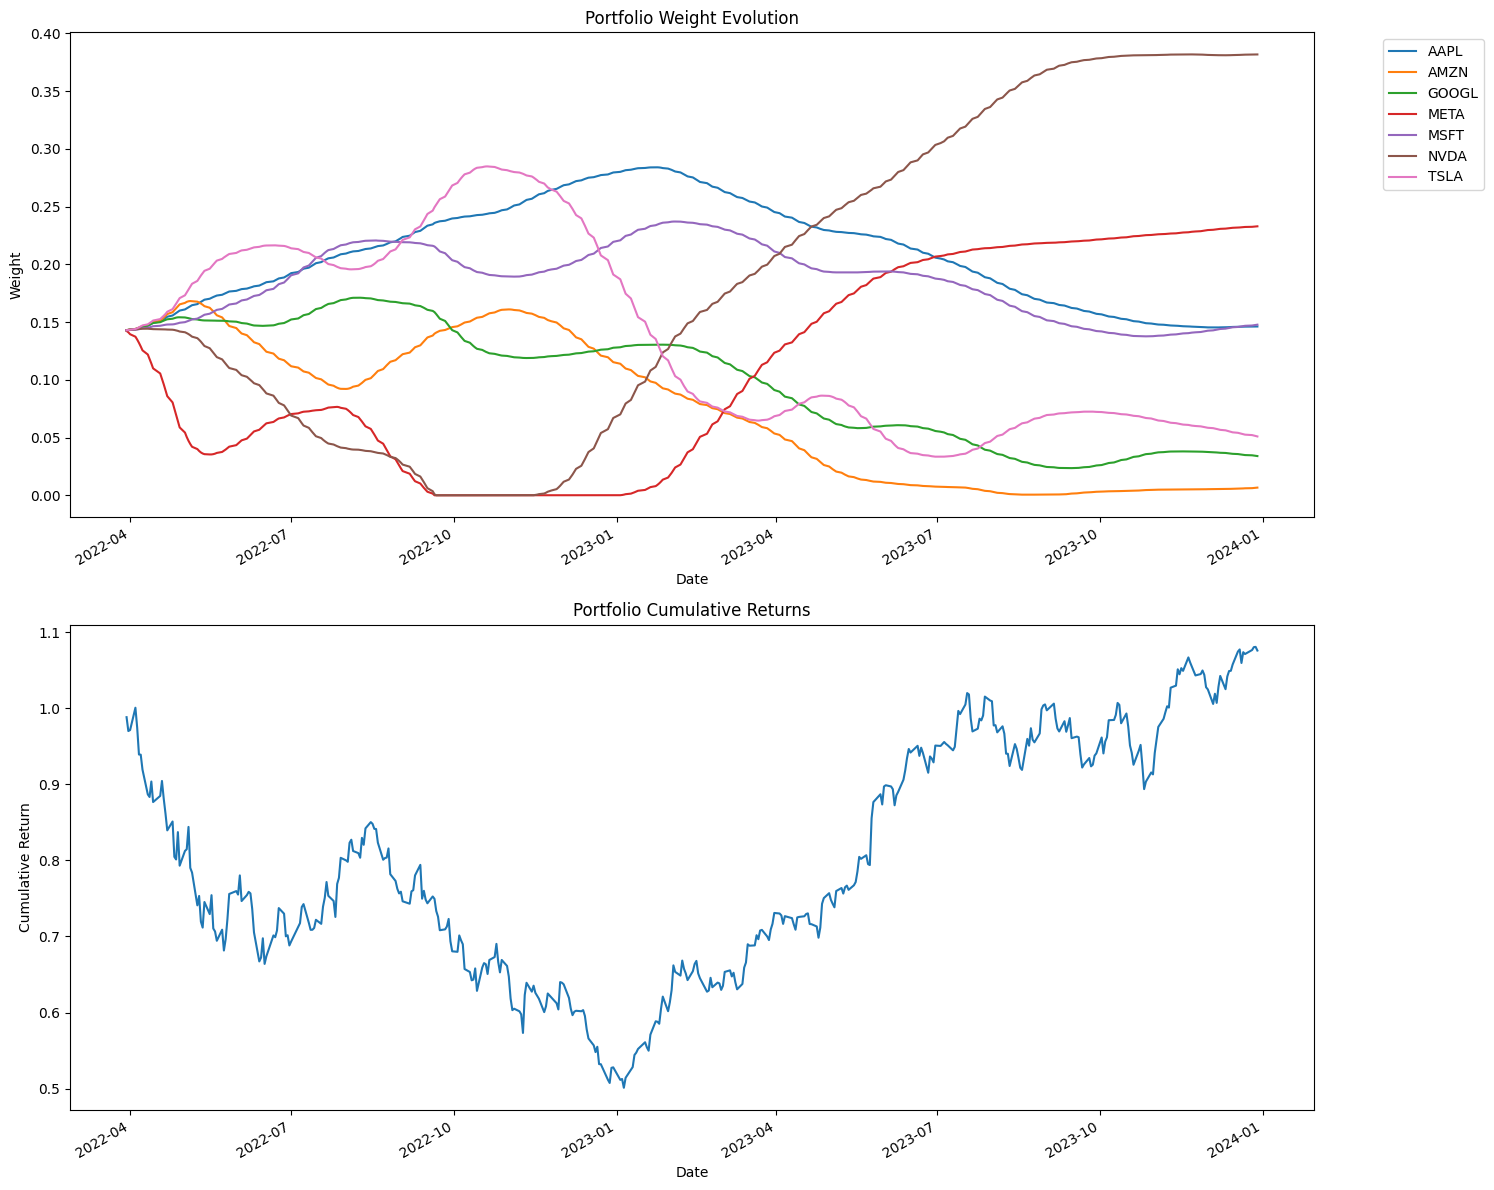


Final portfolio weights:
AAPL: 0.146
AMZN: 0.007
GOOGL: 0.034
META: 0.233
MSFT: 0.148
NVDA: 0.382
TSLA: 0.051


In [ ]:
# First, let's check the data
print("Data shape:", prices.shape)
print("\nFirst few rows:")
print(prices.head())
print("\nColumns:", prices.columns.tolist())

# Initialize the optimizer
optimizer = OnlinePortfolioOptimizer(
    n_assets=len(prices.columns),  # Use number of columns instead of tickers list
    initial_learning_rate=0.01,
    decay_rate=0.995,
    momentum=0.9,
    window_size=60,
    alphas=(1.0, 1.0, 1.0, 0.5),
    max_transaction_cost=0.02
)

# Store results for analysis
weight_history = []
performance_history = []

# Process data day by day
for t in range(60, len(prices)):  # Start after initial window
    # Get data up to current day
    current_prices = prices.iloc[:t+1]

    # Update portfolio weights
    new_weights = optimizer.step(current_prices)

    # Store weights
    weight_history.append({
        'date': prices.index[t],
        **dict(zip(prices.columns, new_weights))
    })

    # Calculate daily return
    daily_returns = (prices.iloc[t] - prices.iloc[t-1]) / prices.iloc[t-1]
    portfolio_return = daily_returns.dot(new_weights)
    performance_history.append({
        'date': prices.index[t],
        'return': portfolio_return
    })

# Convert to DataFrames for analysis
weight_df = pd.DataFrame(weight_history).set_index('date')
performance_df = pd.DataFrame(performance_history).set_index('date')

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot weight evolution
weight_df.plot(ax=ax1)
ax1.set_title('Portfolio Weight Evolution')
ax1.set_xlabel('Date')
ax1.set_ylabel('Weight')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot cumulative returns
cumulative_returns = (1 + performance_df['return']).cumprod()
cumulative_returns.plot(ax=ax2)
ax2.set_title('Portfolio Cumulative Returns')
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Return')

plt.tight_layout()
plt.show()

# Print final weights
print("\nFinal portfolio weights:")
final_weights = dict(zip(prices.columns, optimizer.get_weights()))
for asset, weight in final_weights.items():
    print(f"{asset}: {weight:.3f}")

We now go on to compare the returns and fitness for the 8 fundamental strategies discussed before and hope that ours does better!

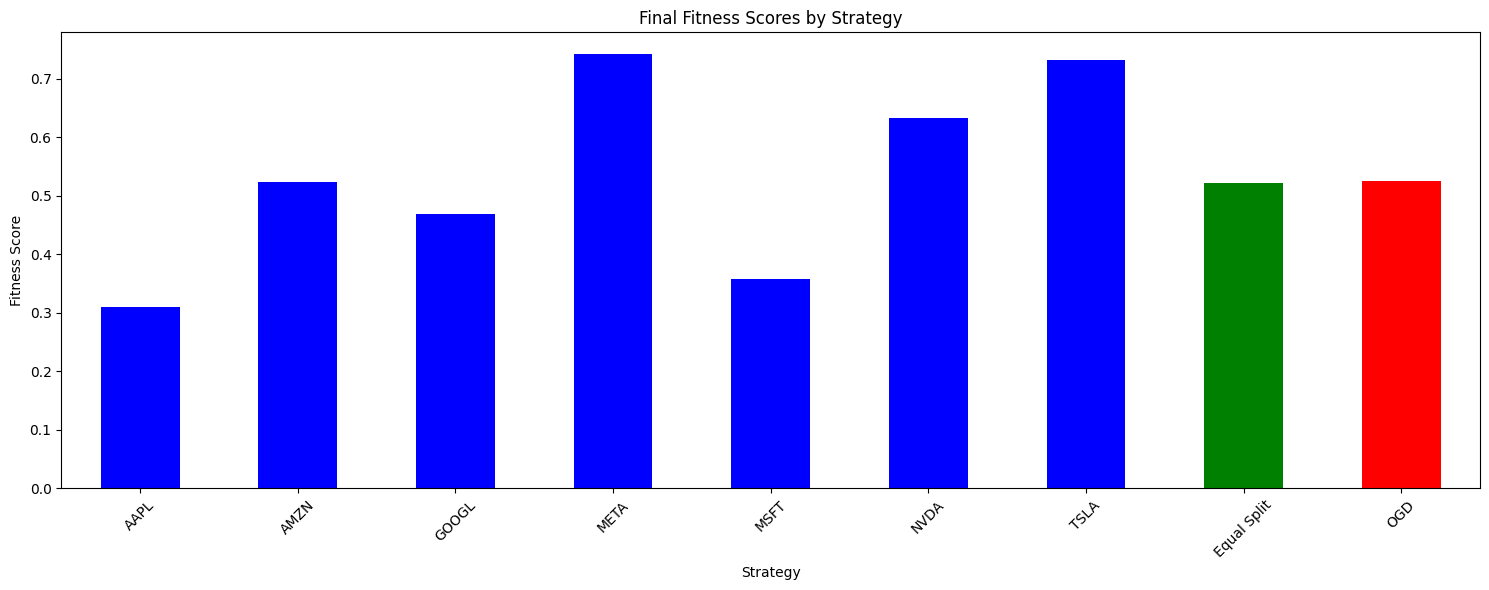

<Figure size 1500x1200 with 0 Axes>

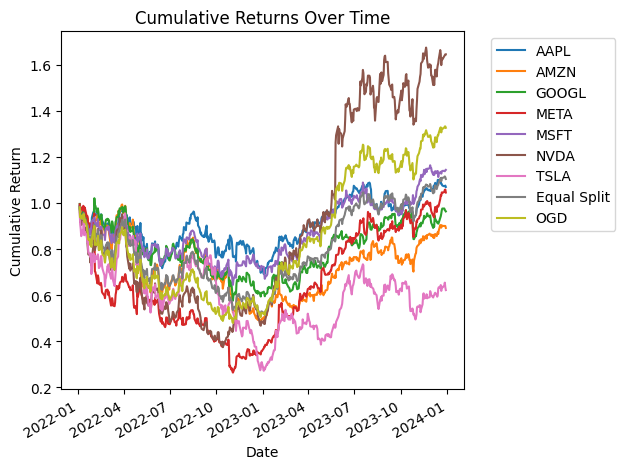


Final Cumulative Returns:
NVDA: 1.65x
OGD: 1.33x
MSFT: 1.14x
Equal Split: 1.10x
AAPL: 1.07x
META: 1.05x
GOOGL: 0.96x
AMZN: 0.89x
TSLA: 0.62x


In [ ]:
# First, let's calculate fundamental strategy returns
def calculate_strategy_returns(prices_df, weights_dict):
    strategy_returns = {}

    for strategy_name, weights in weights_dict.items():
        # Calculate daily returns for the portfolio
        daily_returns = prices_df.pct_change().dropna()
        portfolio_returns = daily_returns.dot(weights)
        cumulative_returns = (1 + portfolio_returns).cumprod()
        strategy_returns[strategy_name] = cumulative_returns

    return pd.DataFrame(strategy_returns)

# Create weights for fundamental strategies
fundamental_strategies = {}
for stock in prices.columns:
    weights = np.zeros(len(prices.columns))
    weights[list(prices.columns).index(stock)] = 1
    fundamental_strategies[f"{stock}"] = weights

# Add equal weight strategy
fundamental_strategies["Equal Split"] = np.ones(len(prices.columns)) / len(prices.columns)

# Add OGD strategy returns from previous calculation
fundamental_strategies["OGD"] = optimizer.get_weights()

# Calculate cumulative returns for all strategies
returns_comparison = calculate_strategy_returns(prices, fundamental_strategies)

# Calculate final fitness scores for all strategies
fitness_scores = {}
for strategy_name, weights in fundamental_strategies.items():
    score = -calculate_fitness(weights, prices)  # Negative because we minimized in the optimization
    fitness_scores[strategy_name] = score

# Create bar plot of fitness scores
plt.figure(figsize=(15, 6))
scores_series = pd.Series(fitness_scores)
colors = ['blue'] * 7 + ['green'] + ['red']  # Individual stocks, Equal Split, OGD
scores_series.plot(kind='bar', color=colors)
plt.title('Final Fitness Scores by Strategy')
plt.xlabel('Strategy')
plt.ylabel('Fitness Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create line plot of cumulative returns
plt.figure(figsize=(15, 12))
returns_comparison.plot()
plt.title('Cumulative Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nFinal Cumulative Returns:")
final_returns = returns_comparison.iloc[-1].sort_values(ascending=False)
for strategy in final_returns.index:
    print(f"{strategy}: {final_returns[strategy]:.2f}x")

We get great returns! However, we want to try and look at online gradent descent methods with different learning rates and window sizes so that we can see which hyperparameter combination performs the best.

Running OGD_Fast_Learning...
Running OGD_Slow_Learning...
Running OGD_High_Momentum...
Running OGD_Low_Momentum...
Running OGD_Short_Window...
Running OGD_Long_Window...
Running OGD_Fast_Decay...
Running OGD_Slow_Decay...
Running OGD_Aggressive...
Running OGD_Conservative...


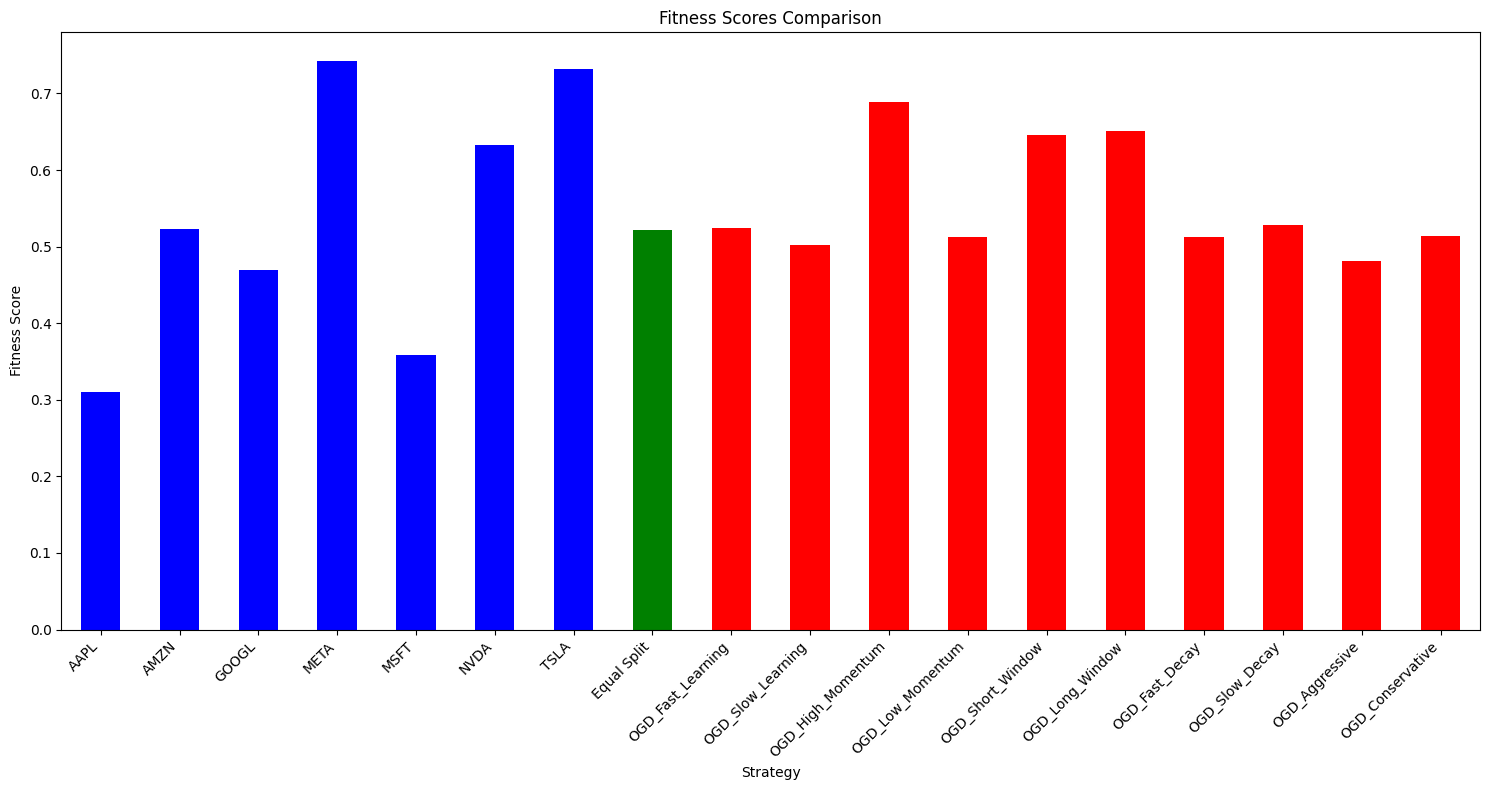

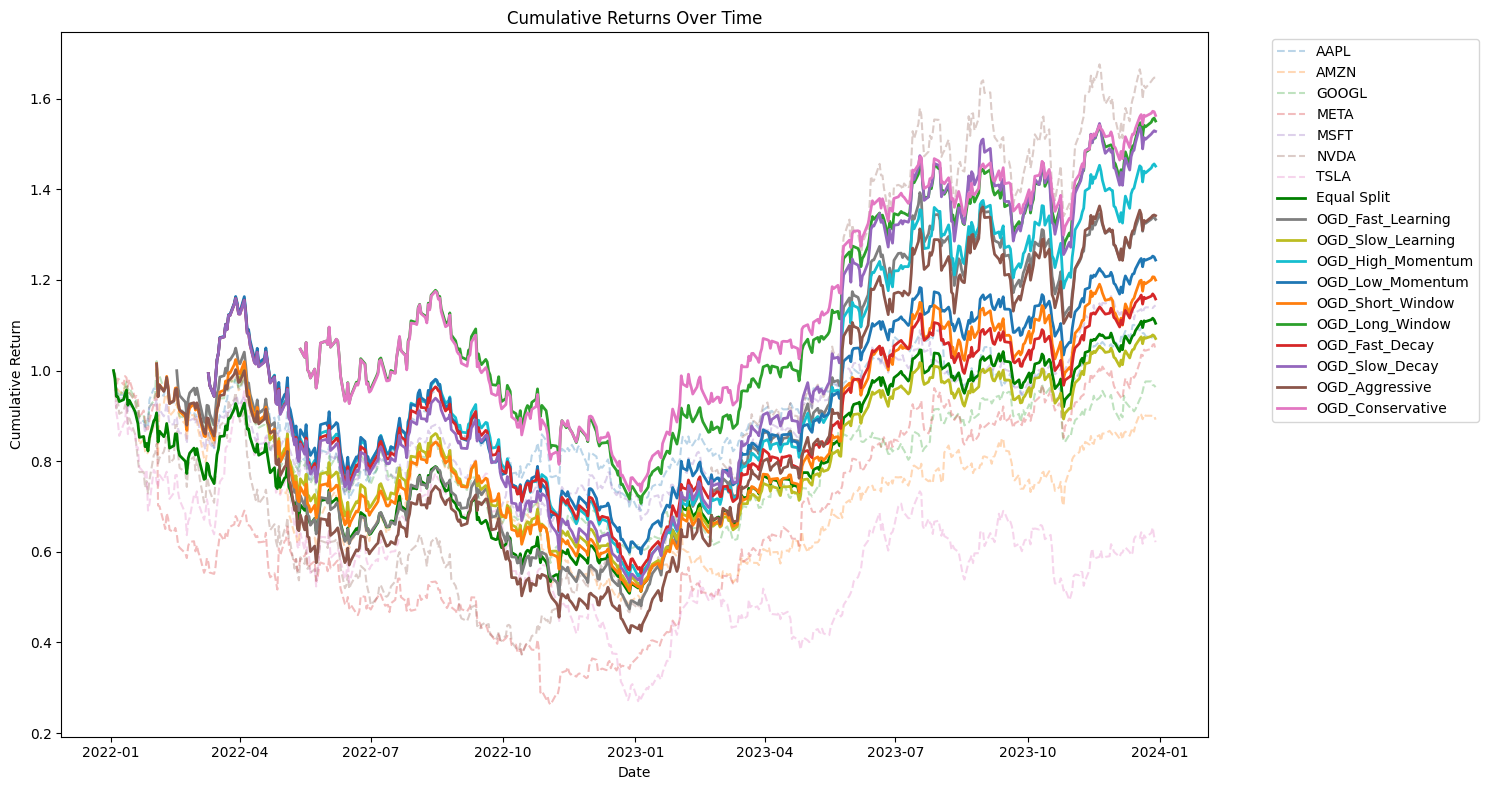


Final Cumulative Returns:
NVDA: 1.65x
OGD_Conservative: 1.56x
OGD_Long_Window: 1.55x
OGD_Slow_Decay: 1.53x
OGD_High_Momentum: 1.45x
OGD_Aggressive: 1.34x
OGD_Fast_Learning: 1.33x
OGD_Low_Momentum: 1.24x
OGD_Short_Window: 1.20x
OGD_Fast_Decay: 1.16x
MSFT: 1.14x
Equal Split: 1.10x
OGD_Slow_Learning: 1.07x
AAPL: 1.07x
META: 1.05x
GOOGL: 0.96x
AMZN: 0.89x
TSLA: 0.62x

Best performing OGD strategy parameters:

OGD_Long_Window:
initial_learning_rate: 0.01
decay_rate: 0.997
momentum: 0.9
window_size: 90

OGD_Conservative:
initial_learning_rate: 0.005
decay_rate: 0.997
momentum: 0.85
window_size: 90


In [ ]:
# Define different hyperparameter configurations
ogd_configs = {
    'OGD_Fast_Learning': {
        'initial_learning_rate': 0.05,
        'decay_rate': 0.999,
        'momentum': 0.8,
        'window_size': 30
    },
    'OGD_Slow_Learning': {
        'initial_learning_rate': 0.005,
        'decay_rate': 0.995,
        'momentum': 0.9,
        'window_size': 60
    },
    'OGD_High_Momentum': {
        'initial_learning_rate': 0.01,
        'decay_rate': 0.997,
        'momentum': 0.95,
        'window_size': 45
    },
    'OGD_Low_Momentum': {
        'initial_learning_rate': 0.01,
        'decay_rate': 0.997,
        'momentum': 0.7,
        'window_size': 45
    },
    'OGD_Short_Window': {
        'initial_learning_rate': 0.01,
        'decay_rate': 0.997,
        'momentum': 0.9,
        'window_size': 20
    },
    'OGD_Long_Window': {
        'initial_learning_rate': 0.01,
        'decay_rate': 0.997,
        'momentum': 0.9,
        'window_size': 90
    },
    'OGD_Fast_Decay': {
        'initial_learning_rate': 0.02,
        'decay_rate': 0.99,
        'momentum': 0.9,
        'window_size': 45
    },
    'OGD_Slow_Decay': {
        'initial_learning_rate': 0.02,
        'decay_rate': 0.999,
        'momentum': 0.9,
        'window_size': 45
    },
    'OGD_Aggressive': {
        'initial_learning_rate': 0.03,
        'decay_rate': 0.998,
        'momentum': 0.95,
        'window_size': 20
    },
    'OGD_Conservative': {
        'initial_learning_rate': 0.005,
        'decay_rate': 0.997,
        'momentum': 0.85,
        'window_size': 90
    }
}

# Initialize and run all OGD variants
ogd_results = {}
ogd_weights = {}

for name, config in ogd_configs.items():
    print(f"Running {name}...")

    # Initialize optimizer with current config
    optimizer = OnlinePortfolioOptimizer(
        n_assets=len(prices.columns),
        initial_learning_rate=config['initial_learning_rate'],
        decay_rate=config['decay_rate'],
        momentum=config['momentum'],
        window_size=config['window_size'],
        alphas=(1.0, 1.0, 1.0, 0.5),
        max_transaction_cost=0.02
    )

    # Store results for analysis
    returns = []
    valid_dates = []

    # Process data day by day
    for t in range(config['window_size'], len(prices)-1):  # Note the -1 to avoid index overflow
        current_prices = prices.iloc[:t+1]
        new_weights = optimizer.step(current_prices)

        # Calculate daily return
        daily_returns = (prices.iloc[t+1] - prices.iloc[t]) / prices.iloc[t]
        portfolio_return = daily_returns.dot(new_weights)

        returns.append(portfolio_return)
        valid_dates.append(prices.index[t+1])

    # Store final weights and cumulative returns
    ogd_weights[name] = optimizer.get_weights()
    ogd_results[name] = (1 + pd.Series(returns, index=valid_dates)).cumprod()

# Calculate fitness scores for all strategies
fitness_scores = {}

# Add fundamental strategies
for stock in prices.columns:
    weights = np.zeros(len(prices.columns))
    weights[list(prices.columns).index(stock)] = 1
    fitness_scores[f"{stock}"] = -calculate_fitness(weights, prices)

# Add equal weight strategy
equal_weights = np.ones(len(prices.columns)) / len(prices.columns)
fitness_scores["Equal Split"] = -calculate_fitness(equal_weights, prices)

# Add OGD strategies
for name, weights in ogd_weights.items():
    fitness_scores[name] = -calculate_fitness(weights, prices)

# Create bar plot of fitness scores
plt.figure(figsize=(15, 8))
scores_series = pd.Series(fitness_scores)
colors = ['blue'] * 7 + ['green'] + ['red'] * 10  # stocks, equal weight, OGD variants
scores_series.plot(kind='bar', color=colors)
plt.title('Fitness Scores Comparison')
plt.xlabel('Strategy')
plt.ylabel('Fitness Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Create line plot of cumulative returns
plt.figure(figsize=(15, 8))

# Plot fundamental strategies
for stock in prices.columns:
    returns = (1 + prices[stock].pct_change()).cumprod()
    plt.plot(returns, alpha=0.3, linestyle='--', label=stock)

# Plot equal weight strategy
equal_weight_returns = (1 + (prices.pct_change() * equal_weights).sum(axis=1)).cumprod()
plt.plot(equal_weight_returns, linewidth=2, label='Equal Split', color='green')

# Plot OGD strategies
for name, returns in ogd_results.items():
    plt.plot(returns, linewidth=2, label=name)

plt.title('Cumulative Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nFinal Cumulative Returns:")
final_returns = {}

# Add fundamental strategies
for stock in prices.columns:
    final_returns[stock] = (1 + prices[stock].pct_change()).cumprod().iloc[-1]

# Add equal weight
final_returns["Equal Split"] = equal_weight_returns.iloc[-1]

# Add OGD strategies
for name, returns in ogd_results.items():
    final_returns[name] = returns.iloc[-1]

# Sort and print
final_returns = pd.Series(final_returns).sort_values(ascending=False)
for strategy in final_returns.index:
    print(f"{strategy}: {final_returns[strategy]:.2f}x")

# Print hyperparameters of best performing OGD strategy
best_ogd = [name for name in ogd_configs.keys() if name in final_returns.index[:3]]
if best_ogd:
    print("\nBest performing OGD strategy parameters:")
    for name in best_ogd:
        print(f"\n{name}:")
        for param, value in ogd_configs[name].items():
            print(f"{param}: {value}")

Excellent returns! Interestingly enough, it seems that the most important strategy parameter was window_size by quite a bit.

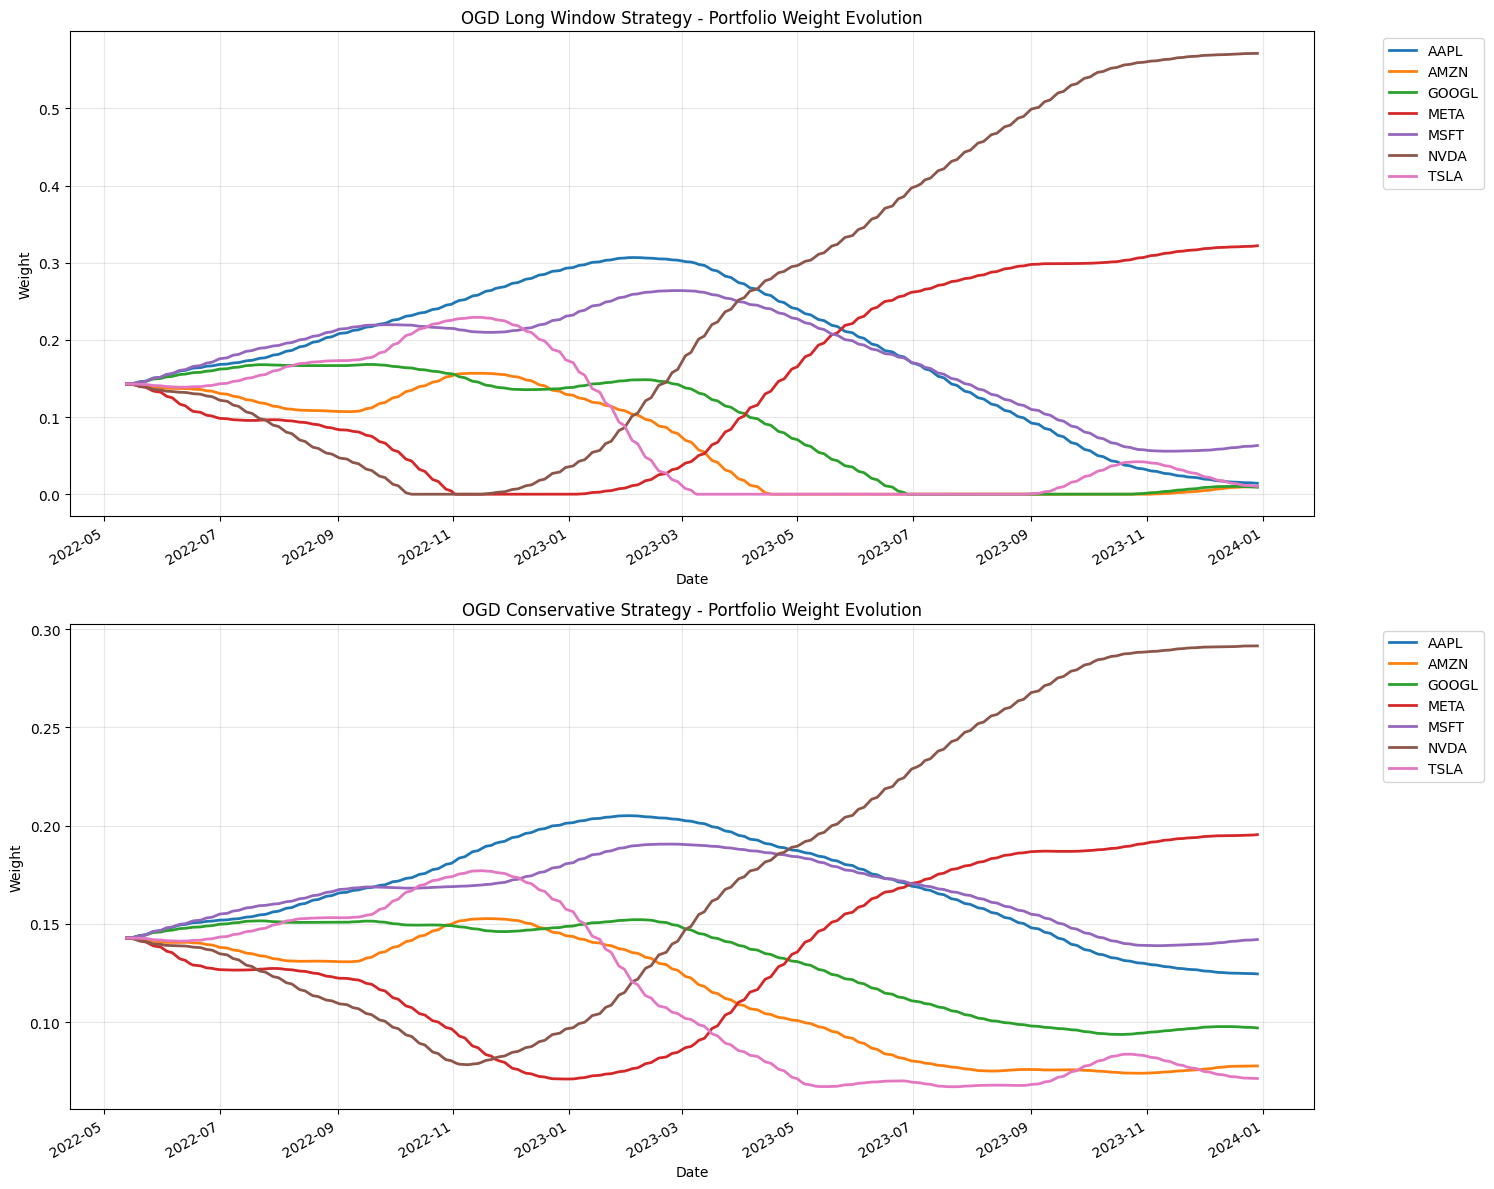


Weight Statistics:

OGD Long Window Strategy:
Average weights:
Ticker
AAPL     0.183
AMZN     0.065
GOOGL    0.090
META     0.151
MSFT     0.177
NVDA     0.251
TSLA     0.084
dtype: float64

Weight volatility (std):
Ticker
AAPL     0.090
AMZN     0.063
GOOGL    0.070
META     0.117
MSFT     0.065
NVDA     0.205
TSLA     0.085
dtype: float64

OGD Conservative Strategy:
Average weights:
Ticker
AAPL     0.167
AMZN     0.112
GOOGL    0.130
META     0.136
MSFT     0.166
NVDA     0.177
TSLA     0.112
dtype: float64

Weight volatility (std):
Ticker
AAPL     0.025
AMZN     0.029
GOOGL    0.023
META     0.042
MSFT     0.016
NVDA     0.074
TSLA     0.040
dtype: float64

Average Daily Turnover:
OGD Long Window: 0.0070
OGD Conservative: 0.0027

Weight Correlation between strategies:
              Long Window  Conservative
Long Window         1.000         0.965
Conservative        0.965         1.000


In [ ]:
# Run the two best strategies again to capture weight history
def run_ogd_with_weight_history(config, prices):
    optimizer = OnlinePortfolioOptimizer(
        n_assets=len(prices.columns),
        initial_learning_rate=config['initial_learning_rate'],
        decay_rate=config['decay_rate'],
        momentum=config['momentum'],
        window_size=config['window_size'],
        alphas=(1.0, 1.0, 1.0, 0.5),
        max_transaction_cost=0.02
    )

    weight_history = []
    valid_dates = []

    for t in range(config['window_size'], len(prices)-1):
        current_prices = prices.iloc[:t+1]
        new_weights = optimizer.step(current_prices)

        weight_history.append(new_weights)
        valid_dates.append(prices.index[t+1])

    return pd.DataFrame(weight_history, index=valid_dates, columns=prices.columns)

# Run both strategies
long_window_weights = run_ogd_with_weight_history(ogd_configs['OGD_Long_Window'], prices)
conservative_weights = run_ogd_with_weight_history(ogd_configs['OGD_Conservative'], prices)

# Create subplots for both strategies
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot Long Window strategy weights
long_window_weights.plot(ax=ax1, linewidth=2)
ax1.set_title('OGD Long Window Strategy - Portfolio Weight Evolution')
ax1.set_xlabel('Date')
ax1.set_ylabel('Weight')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot Conservative strategy weights
conservative_weights.plot(ax=ax2, linewidth=2)
ax2.set_title('OGD Conservative Strategy - Portfolio Weight Evolution')
ax2.set_xlabel('Date')
ax2.set_ylabel('Weight')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nWeight Statistics:")
print("\nOGD Long Window Strategy:")
print("Average weights:")
print(long_window_weights.mean().round(3))
print("\nWeight volatility (std):")
print(long_window_weights.std().round(3))

print("\nOGD Conservative Strategy:")
print("Average weights:")
print(conservative_weights.mean().round(3))
print("\nWeight volatility (std):")
print(conservative_weights.std().round(3))

# Calculate and print turnover
def calculate_average_turnover(weights_df):
    daily_turnover = np.abs(weights_df.diff()).sum(axis=1)
    return daily_turnover.mean()

print("\nAverage Daily Turnover:")
print(f"OGD Long Window: {calculate_average_turnover(long_window_weights):.4f}")
print(f"OGD Conservative: {calculate_average_turnover(conservative_weights):.4f}")

# Calculate correlation between weights
print("\nWeight Correlation between strategies:")
corr = pd.DataFrame({
    'Long Window': long_window_weights.iloc[-1],
    'Conservative': conservative_weights.iloc[-1]
}).corr()
print(corr.round(3))